### Notebook Overview: Txn Classification – LR (w HP Tuning)

This supplementary notebook develops a logistic regression model with hyperparameter tuning to classify Bitcoin transactions from the Elliptic++ dataset as either licit or illicit. It extends the untuned baseline model by systematically optimising model parameters to improve predictive performance, particularly for the minority illicit class. The tuned model serves as a more robust linear benchmark before progressing to non-linear ensemble models such as Random Forest.  

**Purpose**  
The purpose of this notebook is to evaluate how model optimisation enhances the performance of a simple, interpretable classifier. Logistic regression is well suited to this application due to its transparency and its ability to provide clear feature influence through model coefficients. By incorporating regularisation and parameter tuning, the model can balance overfitting and underfitting while improving generalisation to unseen data.  

**Key Steps**  
- Import the labelled transaction dataset from BigQuery, containing licit and illicit transaction classes.  
- Split the data into training and testing sets using stratified sampling to preserve class balance.  
- Define the logistic regression model using `LogisticRegression()` from scikit-learn, incorporating `class_weight='balanced'` to offset the dataset’s strong class imbalance.  
- Conduct hyperparameter tuning using cross-validation (`GridSearchCV`) to optimise the following parameters:  
  - Regularisation penalty: `l1`, `l2`, and `elasticnet`  
  - Regularisation strength: inverse regularisation parameter `C` (log-scaled search range)  
  - Solver: `liblinear` and `saga`  
  - ElasticNet mixing ratio (`l1_ratio`) where applicable  
- Evaluate the tuned model using standard classification metrics including accuracy, precision, recall, F1-score, and ROC-AUC.  
- Compare tuned model results with the untuned baseline and Random Forest model to assess improvement in recall and balanced accuracy for the illicit class.  
- Export tuned model predictions and performance statistics to BigQuery for documentation and further analysis.  

**Outcome**  
The tuned logistic regression model achieves a substantial increase in recall (from approximately 0.69 to 0.92), indicating improved sensitivity to the minority illicit class. However, this gain comes at the cost of lower precision, accuracy, and F1-score, reflecting a higher rate of false positives. AUC-ROC and Gini coefficients improve marginally, suggesting moderate enhancement in rank-order discrimination but limited improvement in overall model balance. These results demonstrate that while hyperparameter tuning can increase illicit detection sensitivity, it reduces model specificity and precision, highlighting the trade-offs inherent in tuning linear classifiers on highly imbalanced data.  

**Context and Attribution**  
This notebook forms part of the technical work developed in support of the research thesis titled:  
_“Detection, Ranking and Visualisation of Money Laundering Networks on the Bitcoin Blockchain”_  
by Jennifer Payne (RMIT University).  

GitHub Repository: [https://github.com/majorpayne-2021/rmit_master_thesis](https://github.com/majorpayne-2021/rmit_master_thesis)  
Elliptic++ Dataset Source: [https://github.com/git-disl/EllipticPlusPlus](https://github.com/git-disl/EllipticPlusPlus)


In [ ]:
# Data cleaning and manipulation
import pandas as pd
import numpy as np
import math

# GCP libraries
from pandas_gbq import to_gbq # write pandas df to a GCP BigQuery table
import gcsfs
import importlib.util
import os
import inspect

import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from scipy.stats import loguniform, uniform


# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Suppress FutureWarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


--------------
##### Read in Txn Classification Classes & Modules
--------------


In [ ]:
# Define bucket and file path
bucket_name = "thesis_classes"
file_name = "txn_classification_hyper.py"
gcs_path = f"gs://{bucket_name}/{file_name}"

# Initialize GCS filesystem
fs = gcsfs.GCSFileSystem()

# Local filename to save the script temporarily
local_file = f"/tmp/{file_name}"

# Download the file from GCS to local storage
fs.get(gcs_path, local_file)

# Dynamically import the module
module_name = "txn_classification"
spec = importlib.util.spec_from_file_location(module_name, local_file)
module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(module)

In [ ]:
# Use inspect to get classes and functions
classes = [name for name, obj in inspect.getmembers(module, inspect.isclass)]

# Print results
print("Classes in module:")
for cls in classes:
    print(f"  - {cls}")


Classes in module:
  - KFold
  - LogisticRegression
  - RandomForestClassifier
  - SimpleImputer
  - StandardScaler
  - build_model
  - model_preprocessing
  - model_reporting


In [ ]:
# Instantiate the classes
preprocessor = module.model_preprocessing()
build_model = module.build_model()
report = module.model_reporting()

--------------
##### Read in Datasets
--------------


In [ ]:
# Read in enhanced txn edgelist table from BigQuery
%%bigquery df_txn_features_clean
select * from `extreme-torch-467913-m6.txn.txn_features_clean`;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
print(df_txn_features_clean.shape)
df_txn_features_clean.dropna().head()

(203769, 198)


,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile
275,148886499,39,3,Unknown,-0.1719,-0.0696,1.0186,-0.1220,-0.0637,-0.1130,-0.0616,-0.1625,-0.1683,-0.0497,-0.1648,-0.0287,-0.0354,-0.0632,-0.0133,-0.0410,-0.1700,-0.1729,-0.1736,-0.2433,-0.2435,-0.1397,-0.1489,-0.0801,-0.1557,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1557,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.0434,-0.2272,-0.2432,-0.0979,-0.2359,0.0366,0.0423,-0.4140,-0.4884,-0.2326,-0.4676,0.0488,0.0530,

In [ ]:
dataset = df_txn_features_clean

-------------------
##### Handle Missing Values
-------------------

In [ ]:
# Handle missing values first
dataset_imputed = preprocessor.handle_missing_values(dataset, ignore_cols = ['txId', 'Time step', 'class_label', 'class'])


===== Missing Value Summary Before Imputation =====
in_txs_degree                965
out_txs_degree               965
total_BTC                    965
fees                         965
size                         965
num_input_addresses          965
num_output_addresses         965
in_BTC_min                   965
in_BTC_max                   965
in_BTC_mean                  965
in_BTC_median                965
in_BTC_total                 965
out_BTC_min                  965
out_BTC_max                  965
out_BTC_mean                 965
out_BTC_median               965
out_BTC_total                965
in_out_ratio                 965
input_output_ratio           965
BTC_dispersion               965
high_fees_flag               965
micro_txn_flag               965
txn_density                  965
fees_per_byte                965
fees_ratio                   965
fees_per_input               965
rounded_amount_flag          965
input_address_percentile     965
output_address_percenti

-------------------
##### Split into Training/Validation and Test Sets
-------------------

In [ ]:
# Preprocess data - split into training/validation and test (blind) datasets.
X, y, X_test, y_test, time_step = preprocessor.split_training_test_data(dataset_imputed)


===== Dataset Summary =====
Total Dataset Size: 203,769

Training/Validation Set: 46,564 (22.9%)
0.0000    42,019 (90.2%)
1.0000    4,545 (9.8%)
Total Training/Validation Size: 46,564
Rows with Missing Values in Training/Validation: 0

Test Set: 157,205 (77.1%)
nan    157,205 (100.0%)
Total Test Size: 157,205
Rows with Missing Values in Test Set: 0


In [ ]:
# Extract indices for Train/Val and Test
train_val_indices = X.index  # Indices of training/validation set
test_indices = X_test.index  # Indices of test set

In [ ]:
# Apply function to label the dataset
dataset_imputed = preprocessor.label_train_val_test(dataset_imputed, train_val_indices, test_indices)

# Verify Labels
class_counts = dataset_imputed.groupby(['data_split', 'class_label']).size().unstack(fill_value=0)
class_counts

class_label,Illicit,Licit,Unknown
data_split,,,
Test,0,0,157205
Train/Val,4545,42019,0


-------------------
##### Training and Validation using Cross-Fold on Temporal Data
-------------------

In [ ]:
drop_training_cols = ['txId', 'Time step', 'class', 'class_label', 'data_split', 'training_label', 'pred_proba']

columns_to_normalize = [
    col for col in dataset.columns
    if col not in drop_training_cols and not col.startswith("Local_feature_") and not col.startswith("Aggregate_feature_")
    ]

print(columns_to_normalize)

['in_txs_degree', 'out_txs_degree', 'total_BTC', 'fees', 'size', 'num_input_addresses', 'num_output_addresses', 'in_BTC_min', 'in_BTC_max', 'in_BTC_mean', 'in_BTC_median', 'in_BTC_total', 'out_BTC_min', 'out_BTC_max', 'out_BTC_mean', 'out_BTC_median', 'out_BTC_total', 'in_out_ratio', 'input_output_ratio', 'BTC_dispersion', 'high_fees_flag', 'micro_txn_flag', 'txn_density', 'fees_per_byte', 'fees_ratio', 'fees_per_input', 'rounded_amount_flag', 'input_address_percentile', 'output_address_percentile']


In [ ]:
# --- Cross-Fold Validation Parameters (unchanged) ---
timestep_field = "Time step"
data_split_field = "data_split"
valid_splits = ['Train/Val']
obs_size = 30000
train_ratio = 0.5
threshold = 0.5
num_folds = 10

In [ ]:
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression

tscv = TimeSeriesSplit(n_splits=3)

halving_lr = HalvingGridSearchCV(
    estimator=LogisticRegression(
        solver="saga",
        penalty="elasticnet",
        class_weight="balanced",
        max_iter=200,              # start small; scheduler increases it
        random_state=42
    ),
    param_grid={
        "C": [0.03, 0.1, 0.3, 1],  # tiny grid
        "l1_ratio": [0.0, 0.5, 1.0]
    },
    resource="max_iter",
    min_resources=200,
    max_resources=2000,
    factor=2,
    scoring="recall",
    cv=tscv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

Processing Fold 1: 30000 observations...


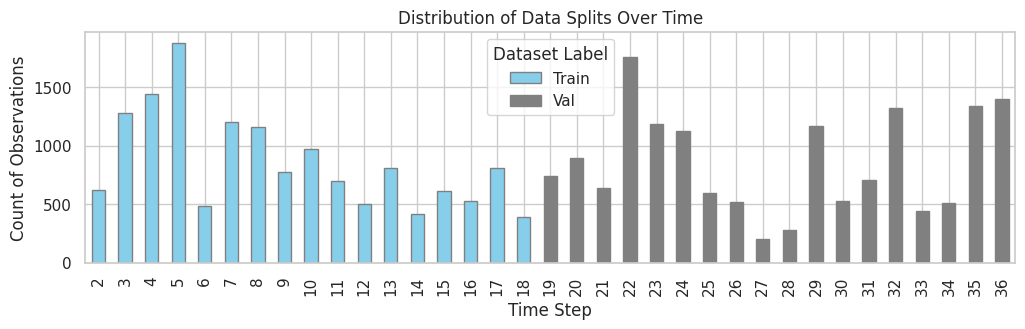

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Processing Fold 2: 30000 observations...


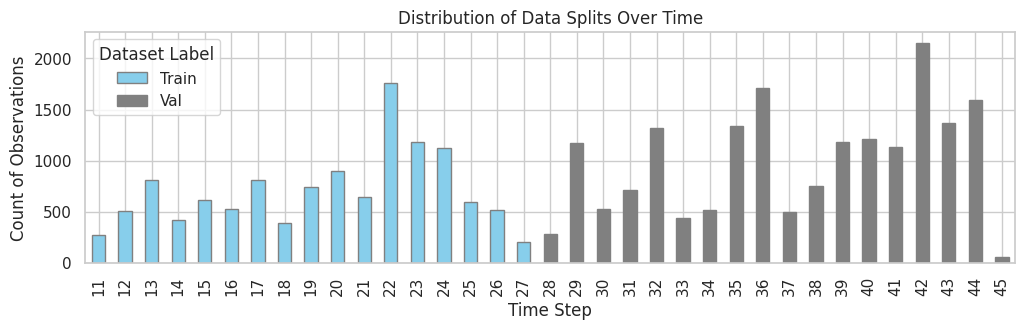

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing Fold 3: 30000 observations...


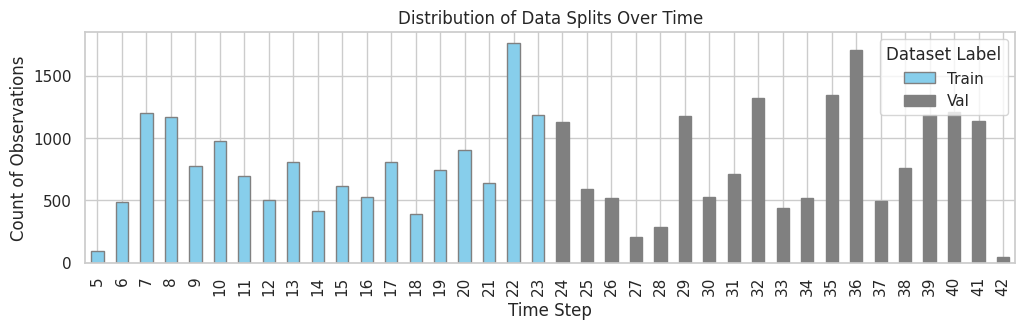

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Processing Fold 4: 30000 observations...


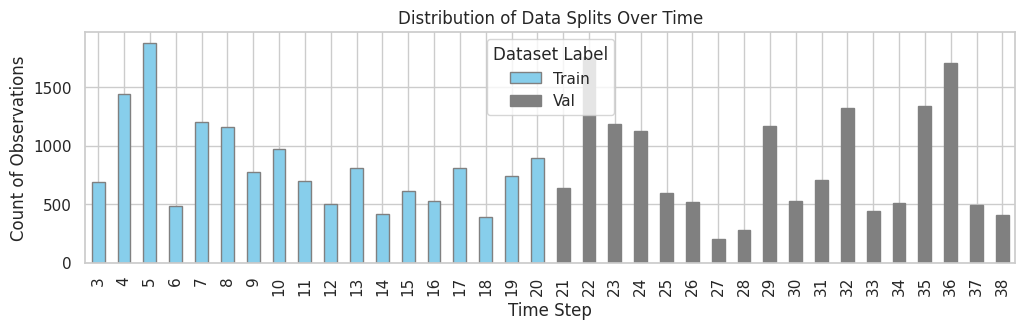

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Processing Fold 5: 30000 observations...


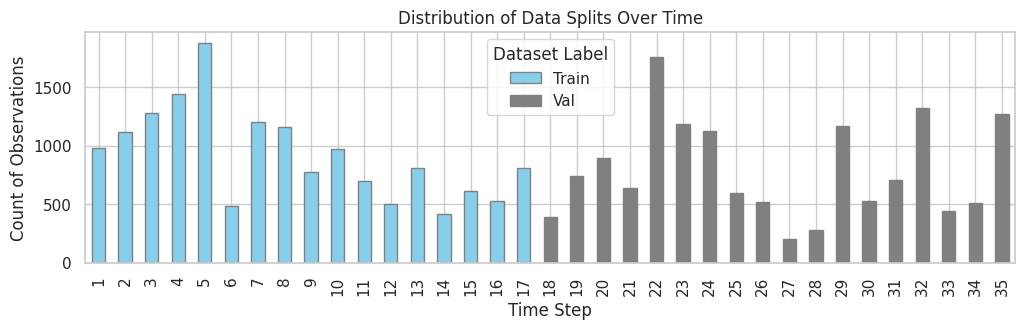

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing Fold 6: 30000 observations...


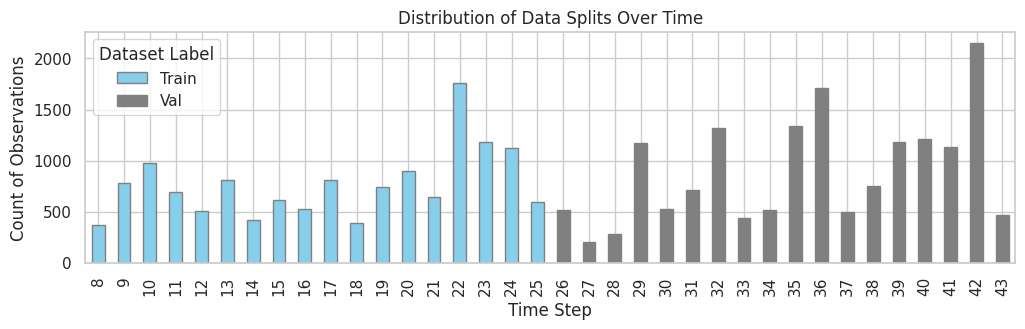

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing Fold 7: 30000 observations...


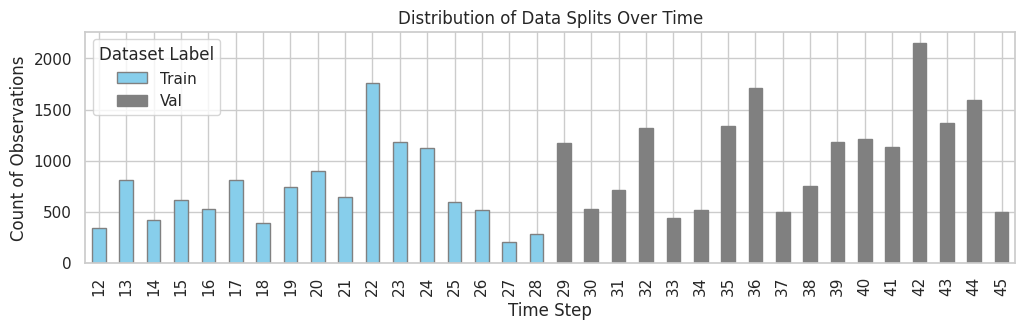

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Processing Fold 8: 30000 observations...


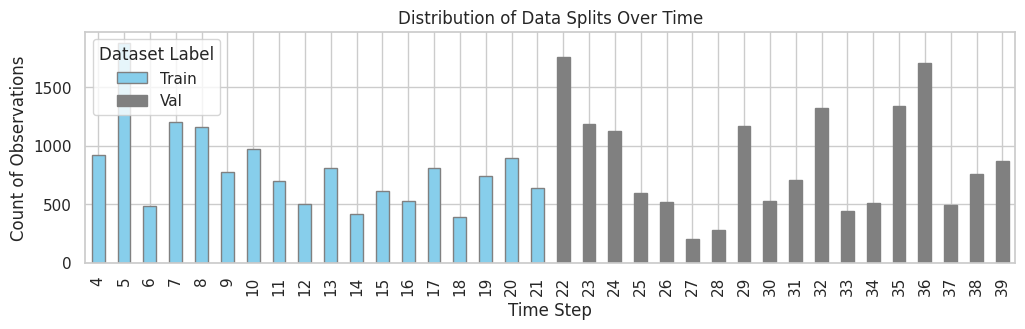

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Processing Fold 9: 30000 observations...


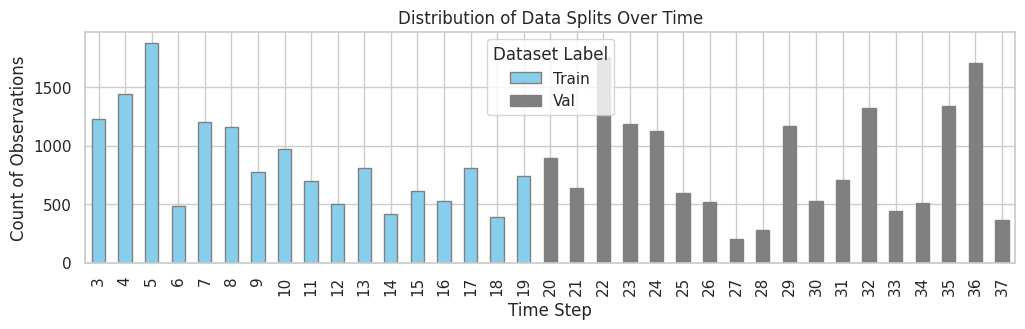

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Processing Fold 10: 30000 observations...


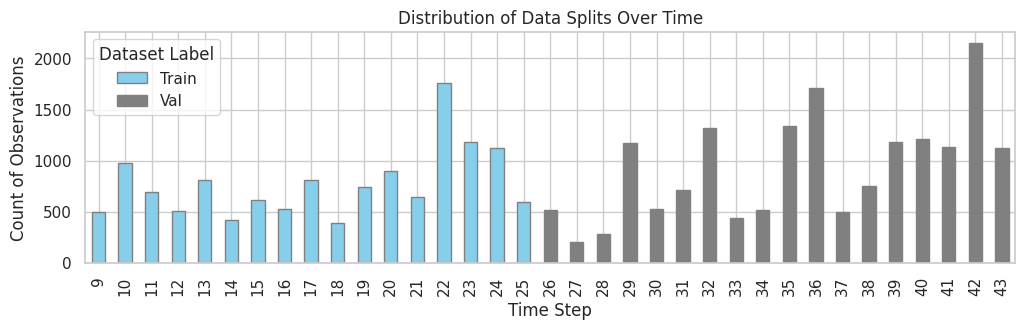

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 200
max_resources_: 2000
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 200
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 400
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 800
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 1600
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
summary_df, trained_models, scalers, fold_indices_dict = build_model.run_cross_validation(
    input_df=dataset_imputed,
    timestep_field=timestep_field,
    drop_training_cols=drop_training_cols,
    columns_to_normalize=columns_to_normalize,
    data_split_field=data_split_field,
    valid_splits=valid_splits,
    model=halving_lr,
    obs_size=obs_size,
    train_ratio=train_ratio,
    threshold=threshold,
    num_folds=num_folds
)

In [ ]:
summary_df

,Fold,Threshold,Total Size,Training Size,Validation Size,Class 0 Size,Class 1 Size,Train Class Distribution,Val Class Distribution,Min Time Step,Max Time Step,Accuracy,Recall,Precision,F1-Score,AUC-ROC,Gini Score,True Positive,True Negative,False Positive,False Negative
0,Fold 1,0.5000,30000,14606,15394,26347,3653,"{0.0: 13199, 1.0: 1407}","{0.0: 13148, 1.0: 2246}",2,36,0.8600,0.8341,0.4588,0.5920,0.9266,0.8531,3047,22753,3594,606
1,Fold 2,0.5000,30000,12031,17969,26178,3822,"{0.0: 10176, 1.0: 1855}","{0.0: 16002, 1.0: 1967}",11,45,0.8363,0.9322,0.4337,0.5920,0.9515,0.9030,3563,21526,4652,259
2,Fold 3,0.5000,30000,14708,15292,25944,4056,"{0.0: 12710, 1.0: 1998}","{0.0: 13234, 1.0: 2058}",5,42,0.8787,0.8536,0.5320,0.6554,0.9416,0.8831,3462,22898,3046,594
3,Fold 4,0.5000,30000,15041,14959,26263,3737,"{0.0: 13311, 1.0: 1730}","{0.0: 12952, 1.0: 2007}",3,38,0.8434,0.8480,0.4342,0.5743,0.9193,0.8385,3169,22133,4130,568
4,Fold 5,0.5000,30000,15688,14312,26375,3625,"{0.0: 14317, 1.0: 1371}","{0.0: 12058, 1.0: 2254}",1,35,0.8545,0.8521,0.4465,0.5860,0.9408,0.8816,3089,22546,3829,536
5,Fold 6,0.5000,30000,13852,16148,25867,4133,"{0.0: 11762, 1.0: 2090}","{0.0: 14105, 1.0: 2043}",8,43,0.8417,0.9448,0.4634,0.6219,0.9551,0.9102,3905,21346,4521,228
6,Fold 7,0.5000,30000,11876,18124,26235,3765,"{0.0: 9995, 1.0: 1881}","{0.0: 16240, 1.0: 1884}",12,45,0.8478,0.9240,0.4483,0.6037,0.9532,0.9063,3479,21954,4281,286
7,Fold 8,0.5000,30000,14466,15534,26156,3844,"{0.0: 12651, 1.0: 1815}","{0.0: 13505, 1.0: 2029}",4,39,0.8659,0.8603,0.4868,0.6218,0.9274,0.8547,3307,22670,3486,537
8,Fold 9,0.5000,30000,14677,15323,26334,3666,"{0.0: 13201, 1.0: 1476}","{0.0: 13133, 1.0: 2190}",3,37,0.8624,0.8317,0.4649,0.5964,0.9244,0.8488,3049,22824,3510,617
9,Fold 10,0.5000,30000,13202,16798,25974,4026,"{0.0: 11232, 1.0: 1970}","{0.0: 14742, 1.0: 2056}",9,43,0.8354,0.9451,0.4464,0.6064,0.9512,0.9023,3805,21256,4718,221


-------------------
##### Select Best Model from Cross-Fold Validation
-------------------

In [ ]:
# Assuming cross_fold_summary, saved_models, and saved_scalers dictionaries are defined
best_model, best_scaler = build_model.select_best_model_and_scaler(cross_fold_summary = summary_df, saved_models = trained_models, saved_scalers = scalers, top_n = 5)

Top Models Ranked:
1. Fold 6 - Gini Score: 0.9102, Recall: 0.9448, Accuracy: 0.8417, AUC-ROC: 0.9551, Precision: 0.4634, F1-Score: 0.6219
2. Fold 7 - Gini Score: 0.9063, Recall: 0.9240, Accuracy: 0.8478, AUC-ROC: 0.9532, Precision: 0.4483, F1-Score: 0.6037
3. Fold 2 - Gini Score: 0.9030, Recall: 0.9322, Accuracy: 0.8363, AUC-ROC: 0.9515, Precision: 0.4337, F1-Score: 0.5920
4. Fold 10 - Gini Score: 0.9023, Recall: 0.9451, Accuracy: 0.8354, AUC-ROC: 0.9512, Precision: 0.4464, F1-Score: 0.6064
5. Fold 3 - Gini Score: 0.8831, Recall: 0.8536, Accuracy: 0.8787, AUC-ROC: 0.9416, Precision: 0.5320, F1-Score: 0.6554

Best Model Selected: Fold 6


In [ ]:
# Get feature names used during training
#print(best_model.feature_names_in_)

Load model and scaler, trained on training data during cross-fold

In [ ]:
# OR manually select model and scaler
#best_model = trained_models['Fold 4']
#best_scaler = scalers['Fold 4']

-------------------
##### Most Important Features for Best Model
-------------------

In [ ]:
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

# === set this explicitly to the fold your function printed ===
selected_fold = "Fold 6"   # e.g., "Fold 4" based on your Top Models Ranked

# Use your already-selected objects
est = best_model.best_estimator_ if hasattr(best_model, "best_estimator_") else best_model
scaler = best_scaler

# ---- Build the OUTER-VALIDATION slice for that fold (explicit, no auto-detect) ----
val_idx = fold_indices_dict[selected_fold]["val_indices"]
Xv = dataset_imputed.loc[val_idx, est.feature_names_in_].copy()
yv = dataset_imputed.loc[val_idx, "class"].astype(int).values

# Apply the same scaling used during CV (only to the normalized columns)
norm_cols = [c for c in Xv.columns if c in columns_to_normalize]
if norm_cols and scaler is not None:
    Xv.loc[:, norm_cols] = scaler.transform(Xv[norm_cols])

# ---- Permutation importance (choose your metric) ----
perm_metric = "f1"   # or "recall" if recall is your focus
perm = permutation_importance(
    est, Xv, yv,
    n_repeats=10,
    scoring=perm_metric,
    n_jobs=-1,
    random_state=42
)

perm_df = (
    pd.DataFrame({
        "feature": est.feature_names_in_,
        "perm_importance_mean": perm.importances_mean,
        "perm_importance_std": perm.importances_std
    })
    .sort_values("perm_importance_mean", ascending=False)
    .reset_index(drop=True)
)

# Optional: normalise to 0–100 for nicer presentation
top = perm_df["perm_importance_mean"].max()
if top and top > 0:
    perm_df["perm_importance_index_0_100"] = (100 * perm_df["perm_importance_mean"] / top).round(1)

# ---- Gini (impurity) importances from the RF ----
gini_df = (
    pd.DataFrame({
        "feature": est.feature_names_in_,
        "gini_importance": getattr(est, "feature_importances_", np.zeros(len(est.feature_names_in_)))
    })
    .sort_values("gini_importance", ascending=False)
    .reset_index(drop=True)
)

# ---- Combined (nice for thesis) ----
imp_merged = (
    perm_df[["feature","perm_importance_mean","perm_importance_std"]]
    .merge(gini_df, on="feature", how="outer")
    .assign(
        rank_perm=lambda d: d["perm_importance_mean"].rank(ascending=False, method="min"),
        rank_gini=lambda d: d["gini_importance"].rank(ascending=False, method="min")
    )
    .sort_values("rank_perm")
    .reset_index(drop=True)
)

# Peek
display(perm_df.head(20))
display(gini_df.head(20))
display(imp_merged.head(25))


,feature,perm_importance_mean,perm_importance_std,perm_importance_index_0_100
0,output_address_percentile,0.0833,0.0032,100.0000
1,Local_feature_46,0.0176,0.0018,21.1000
2,Local_feature_49,0.0169,0.0016,20.3000
3,Local_feature_47,0.0166,0.0016,19.9000
4,Local_feature_84,0.0142,0.0013,17.1000
5,Local_feature_87,0.0128,0.0017,15.4000
6,Local_feature_86,0.0123,0.0015,14.8000
7,Local_feature_83,0.0106,0.0012,12.8000
8,fees,0.0073,0.0012,8.7000
9,Local_feature_85,0.0064,0.0011,7.7000


,feature,gini_importance
0,Local_feature_1,0.0000
1,Local_feature_2,0.0000
2,Local_feature_3,0.0000
3,Local_feature_4,0.0000
4,Local_feature_5,0.0000
5,Local_feature_6,0.0000
6,Local_feature_7,0.0000
7,Local_feature_8,0.0000
8,Local_feature_9,0.0000
9,Local_feature_10,0.0000


,feature,perm_importance_mean,perm_importance_std,gini_importance,rank_perm,rank_gini
0,output_address_percentile,0.0833,0.0032,0.0000,1.0000,1.0000
1,Local_feature_46,0.0176,0.0018,0.0000,2.0000,1.0000
2,Local_feature_49,0.0169,0.0016,0.0000,3.0000,1.0000
3,Local_feature_47,0.0166,0.0016,0.0000,4.0000,1.0000
4,Local_feature_84,0.0142,0.0013,0.0000,5.0000,1.0000
5,Local_feature_87,0.0128,0.0017,0.0000,6.0000,1.0000
6,Local_feature_86,0.0123,0.0015,0.0000,7.0000,1.0000
7,Local_feature_83,0.0106,0.0012,0.0000,8.0000,1.0000
8,fees,0.0073,0.0012,0.0000,9.0000,1.0000
9,Local_feature_85,0.0064,0.0011,0.0000,10.0000,1.0000


-------------------
##### Apply Best Model to Training and Validation Data
-------------------

Apply scaler to full dataset

In [ ]:
test_normalize_cols = columns_to_normalize
print(test_normalize_cols)

['in_txs_degree', 'out_txs_degree', 'total_BTC', 'fees', 'size', 'num_input_addresses', 'num_output_addresses', 'in_BTC_min', 'in_BTC_max', 'in_BTC_mean', 'in_BTC_median', 'in_BTC_total', 'out_BTC_min', 'out_BTC_max', 'out_BTC_mean', 'out_BTC_median', 'out_BTC_total', 'in_out_ratio', 'input_output_ratio', 'BTC_dispersion', 'high_fees_flag', 'micro_txn_flag', 'txn_density', 'fees_per_byte', 'fees_ratio', 'fees_per_input', 'rounded_amount_flag', 'input_address_percentile', 'output_address_percentile']


In [ ]:
# Make a copy of the dataset to avoid modifying the original
dataset_bestmodel = dataset_imputed[dataset_imputed['data_split'] == 'Train/Val'].copy()

# Apply the fitted scaler from Fold 8 to the full dataset
dataset_bestmodel[test_normalize_cols] = best_scaler.transform(dataset_bestmodel[test_normalize_cols])

In [ ]:
dataset_bestmodel.head(3)

,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,data_split
2,152338737,39,0.0000,Licit,-0.0468,-0.0150,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.0346,-0.0422,-0.0497,-0.0370,-0.0287,-0.0354,-0.0430,-0.0133,0.0110,-0.0463,-0.0350,-0.0269,0.8871,0.8846,-0.1397,-0.1489,-0.0801,-0.1556,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1556,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.0434,-0.2272,-0.2432,-0.0979,-0.2359,0.0366,0.0423,-0.4139,-0.4883,-0.2326,-0.4675,0.048

Apply the model for predictions

In [ ]:
# Get the exact features used during training
trained_features = best_model.feature_names_in_

# Drop unnecessary fields before prediction
dataset_bestmodel_pred = dataset_bestmodel[trained_features].copy()

# Generate predictions using the trained model
dataset_bestmodel_pred['pred_proba'] = best_model.predict_proba(dataset_bestmodel_pred)[:, 1]

In [ ]:
dataset_bestmodel_pred.head()

,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,pred_proba
2,-0.0468,-0.0150,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.0346,-0.0422,-0.0497,-0.0370,-0.0287,-0.0354,-0.0430,-0.0133,0.0110,-0.0463,-0.0350,-0.0269,0.8871,0.8846,-0.1397,-0.1489,-0.0801,-0.1556,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1556,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.0434,-0.2272,-0.2432,-0.0979,-0.2359,0.0366,0.0423,-0.4139,-0.4883,-0.2326,-0.4675,0.0488,0.0530,-0.0391,-0.1729,-0.1631,-0.1609,0.9235,0.9230,-0.0

In [ ]:
# Map the predicted probability column
dataset_bestmodel['pred_proba'] = dataset_bestmodel_pred['pred_proba']

In [ ]:
# Build pred bins
list_bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
dataset_bestmodel_pred = preprocessor.build_bins_manually(input_df = dataset_bestmodel
                                                          , field_risk_score='pred_proba'
                                                          , list_bin_thresholds=list_bins)

In [ ]:
print(dataset_bestmodel.shape)
dataset_bestmodel.head()

(46564, 203)


,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,data_split,pred_proba,pred_bin,pred_bin_LOWERB,pred_bin_UPPERB
2,152338737,39,0.0000,Licit,-0.0468,-0.0150,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.0346,-0.0422,-0.0497,-0.0370,-0.0287,-0.0354,-0.0430,-0.0133,0.0110,-0.0463,-0.0350,-0.0269,0.8871,0.8846,-0.1397,-0.1489,-0.0801,-0.1556,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1556,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.0434,-0.2272,-0.2432,-0.0979,-0.2359

-------------------
##### Performance at different thresholds (confusion matrix)
-------------------

In [ ]:
# Build binned pred report
evaluation_report = report.build_binned_pred_report(dataset_bestmodel)
evaluation_report

,Illicit,Licit,TOTAL,Illicit_PCT,Licit_PCT,TOTAL_PCT,Illicit_CUMPCT,Licit_CUMPCT,TOTAL_CUMPCT,Illicit_Licit_ODDS,Illicit_CONVERSION
0.0-0.1,110.0000,29529.0000,29639.0000,0.0240,0.7030,0.6370,0.0240,0.7030,0.6370,0.0000,0.0000
0.1-0.2,60.0000,2349.0000,2409.0000,0.0130,0.0560,0.0520,0.0370,0.7590,0.6880,0.0300,0.0200
0.2-0.3,53.0000,1413.0000,1466.0000,0.0120,0.0340,0.0310,0.0490,0.7920,0.7200,0.0400,0.0400
0.3-0.4,68.0000,1103.0000,1171.0000,0.0150,0.0260,0.0250,0.0640,0.8190,0.7450,0.0600,0.0600
0.4-0.5,89.0000,925.0000,1014.0000,0.0200,0.0220,0.0220,0.0840,0.8410,0.7670,0.1000,0.0900
0.5-0.6,120.0000,873.0000,993.0000,0.0260,0.0210,0.0210,0.1100,0.8610,0.7880,0.1400,0.1200
0.6-0.7,152.0000,906.0000,1058.0000,0.0330,0.0220,0.0230,0.1440,0.8830,0.8110,0.1700,0.1400
0.7-0.8,249.0000,1129.0000,1378.0000,0.0550,0.0270,0.0300,0.1980,0.9100,0.8400,0.2200,0.1800
0.8-0.9,408.0000,1490.0000,1898.0000,0.0900,0.0350,0.0410,0.2880,0.9450,0.8810,0.2700,0.2100
0.9-1,3233.0000,2296.0000,5529.0000,0.7120,0.0550,0.1190,1.0000,1.0000,1.0000,1.4100,0.5800


In [ ]:
# See confusion matrix at different thresholds
cm_report, cm_results_df = report.calculate_cm_performance(dataset_bestmodel,
                                                    field_class_binary='class',
                                                    field_pred_proba='pred_proba')

In [ ]:
cm_report

,ACCURACY,RECALL,PRECISION,F1,TRUE_POSITIVE,TRUE_NEGATIVE,FALSE_POSITIVE,FALSE_NEGATIVE,TOTAL
THRESHOLD,,,,,,,,,
0.1000,0.7300,0.9800,0.2600,0.4100,4435,29529,12490,110,46564
0.2000,0.7800,0.9600,0.3000,0.4600,4375,31878,10141,170,46564
0.3000,0.8100,0.9500,0.3300,0.4900,4322,33291,8728,223,46564
0.4000,0.8300,0.9400,0.3600,0.5200,4254,34394,7625,291,46564
0.5000,0.8500,0.9200,0.3800,0.5400,4165,35319,6700,380,46564
0.6000,0.8600,0.8900,0.4100,0.5600,4045,36192,5827,500,46564
0.7000,0.8800,0.8600,0.4400,0.5800,3893,37098,4921,652,46564
0.8000,0.9000,0.8000,0.4900,0.6100,3644,38227,3792,901,46564
0.9000,0.9200,0.7100,0.5800,0.6400,3236,39717,2302,1309,46564


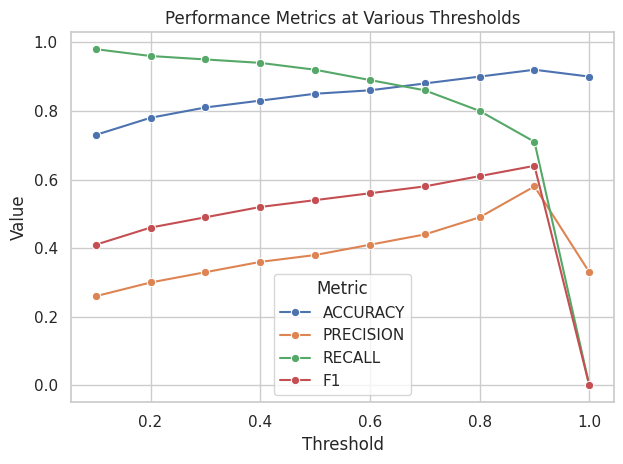

In [ ]:
report.plot_cm_metrics(input_df=cm_results_df,
                plot_x_axis='THRESHOLD',
                plot_value='VALUE',
                classes='METRIC')

# threshold of 0.5 is an appropriate threshold as it's a good balance between accuracy and recall, given imbalanced dataset.

In [ ]:
# Apply the threshold to create the pred_class. Returns True (1) or False (0) based on the threshold.
illicit_threshold = 0.5
dataset_bestmodel['pred_class'] = (dataset_bestmodel['pred_proba'] >= illicit_threshold).astype(int)

# Map numeric classes to labels
dataset_bestmodel['pred_class_label'] = dataset_bestmodel['pred_class'].map({1: "Illicit", 0: "Licit"})

In [ ]:
# Evaluate model performance
report.evaluate_final_model(y_true = dataset_bestmodel['class'], y_pred = dataset_bestmodel['pred_class'], label = f"Best Model w {illicit_threshold:.2f} Threshold")

,Label,Total Size,Accuracy,Recall,Precision,F1-Score,AUC-ROC,Gini Score,True Positive,True Negative,False Positive,False Negative
0,Best Model w 0.50 Threshold,46564,0.8480,0.9164,0.3833,0.5406,0.8785,0.7569,4165,35319,6700,380


-------------------
##### Blind Test - Label Unknown Txn Classes
-------------------

In [ ]:
test_normalize_cols = columns_to_normalize

# Make a copy of the dataset to avoid modifying the original
dataset_final_pred = dataset_imputed.copy()

# Apply the fitted scaler to the full dataset
dataset_final_pred[test_normalize_cols] = best_scaler.transform(dataset_final_pred[test_normalize_cols])

In [ ]:
# Get the exact features used during training
trained_features = best_model.feature_names_in_

# Drop unnecessary fields before prediction
dataset_final_pred = dataset_final_pred[trained_features].copy()

# Generate predictions using the trained model
dataset_final_pred['pred_proba'] = best_model.predict_proba(dataset_final_pred)[:, 1]

In [ ]:
# Map the predicted probability column
dataset_final = df_txn_features_clean.copy()

# Apply prediction to dataset final
dataset_final['pred_proba'] = dataset_final_pred['pred_proba']

# Apply the threshold to create the pred_class. Returns True (1) or False (0) based on the threshold.
dataset_final['pred_class'] = (dataset_final['pred_proba'] >= 0.5).astype(int)

# Map numeric classes to labels
dataset_final['pred_class_label'] = dataset_final['pred_class'].map({1: "Illicit", 0: "Licit"})

In [ ]:
# If 'class' is 'licit' or 'illicit', keep it; otherwise, use 'pred_class'
dataset_final['final_class'] = np.where(dataset_final['class'].isin([0, 1]),
                                        dataset_final['class'],
                                        dataset_final['pred_class'])

dataset_final['final_class_label'] = np.where(dataset_final['class_label'].isin(['Licit', 'Illicit']),
                                        dataset_final['class_label'],
                                        dataset_final['pred_class_label'])

In [ ]:
print(dataset_final.shape)
dataset_final.head(3)

(203769, 203)


,txId,Time step,class,class_label,Local_feature_1,Local_feature_2,Local_feature_3,Local_feature_4,Local_feature_5,Local_feature_6,Local_feature_7,Local_feature_8,Local_feature_9,Local_feature_10,Local_feature_11,Local_feature_12,Local_feature_13,Local_feature_14,Local_feature_15,Local_feature_16,Local_feature_17,Local_feature_18,Local_feature_19,Local_feature_20,Local_feature_21,Local_feature_22,Local_feature_23,Local_feature_24,Local_feature_25,Local_feature_26,Local_feature_27,Local_feature_28,Local_feature_29,Local_feature_30,Local_feature_31,Local_feature_32,Local_feature_33,Local_feature_34,Local_feature_35,Local_feature_36,Local_feature_37,Local_feature_38,Local_feature_39,Local_feature_40,Local_feature_41,Local_feature_42,Local_feature_43,Local_feature_44,Local_feature_45,Local_feature_46,Local_feature_47,Local_feature_48,Local_feature_49,Local_feature_50,Local_feature_51,Local_feature_52,Local_feature_53,Local_feature_54,Local_feature_55,Local_feature_56,Local_feature_57,Local_feature_58,Local_feature_59,Local_feature_60,Local_feature_61,Local_feature_62,Local_feature_63,Local_feature_64,Local_feature_65,Local_feature_66,Local_feature_67,Local_feature_68,Local_feature_69,Local_feature_70,Local_feature_71,Local_feature_72,Local_feature_73,Local_feature_74,Local_feature_75,Local_feature_76,Local_feature_77,Local_feature_78,Local_feature_79,Local_feature_80,Local_feature_81,Local_feature_82,Local_feature_83,Local_feature_84,Local_feature_85,Local_feature_86,Local_feature_87,Local_feature_88,Local_feature_89,Local_feature_90,Local_feature_91,Local_feature_92,Local_feature_93,Aggregate_feature_1,Aggregate_feature_2,Aggregate_feature_3,Aggregate_feature_4,Aggregate_feature_5,Aggregate_feature_6,Aggregate_feature_7,Aggregate_feature_8,Aggregate_feature_9,Aggregate_feature_10,Aggregate_feature_11,Aggregate_feature_12,Aggregate_feature_13,Aggregate_feature_14,Aggregate_feature_15,Aggregate_feature_16,Aggregate_feature_17,Aggregate_feature_18,Aggregate_feature_19,Aggregate_feature_20,Aggregate_feature_21,Aggregate_feature_22,Aggregate_feature_23,Aggregate_feature_24,Aggregate_feature_25,Aggregate_feature_26,Aggregate_feature_27,Aggregate_feature_28,Aggregate_feature_29,Aggregate_feature_30,Aggregate_feature_31,Aggregate_feature_32,Aggregate_feature_33,Aggregate_feature_34,Aggregate_feature_35,Aggregate_feature_36,Aggregate_feature_37,Aggregate_feature_38,Aggregate_feature_39,Aggregate_feature_40,Aggregate_feature_41,Aggregate_feature_42,Aggregate_feature_43,Aggregate_feature_44,Aggregate_feature_45,Aggregate_feature_46,Aggregate_feature_47,Aggregate_feature_48,Aggregate_feature_49,Aggregate_feature_50,Aggregate_feature_51,Aggregate_feature_52,Aggregate_feature_53,Aggregate_feature_54,Aggregate_feature_55,Aggregate_feature_56,Aggregate_feature_57,Aggregate_feature_58,Aggregate_feature_59,Aggregate_feature_60,Aggregate_feature_61,Aggregate_feature_62,Aggregate_feature_63,Aggregate_feature_64,Aggregate_feature_65,Aggregate_feature_66,Aggregate_feature_67,Aggregate_feature_68,Aggregate_feature_69,Aggregate_feature_70,Aggregate_feature_71,Aggregate_feature_72,in_txs_degree,out_txs_degree,total_BTC,fees,size,num_input_addresses,num_output_addresses,in_BTC_min,in_BTC_max,in_BTC_mean,in_BTC_median,in_BTC_total,out_BTC_min,out_BTC_max,out_BTC_mean,out_BTC_median,out_BTC_total,in_out_ratio,input_output_ratio,BTC_dispersion,high_fees_flag,micro_txn_flag,txn_density,fees_per_byte,fees_ratio,fees_per_input,rounded_amount_flag,input_address_percentile,output_address_percentile,pred_proba,pred_class,pred_class_label,final_class,final_class_label
0,30549576,8,3,Unknown,-0.1700,-0.1805,1.0186,-0.1220,-0.0439,-0.1130,-0.0616,-0.1606,-0.1665,-0.0497,-0.1629,-0.0287,-0.0354,-0.0430,-0.0133,-0.0542,-0.1684,-0.1700,-0.1728,-1.3737,-1.3715,-0.1397,-0.1489,-0.0801,-0.1557,-0.0108,-0.0121,-0.1397,-0.1489,-0.0801,-0.1557,-0.0107,-0.0120,-0.0247,-0.0313,-0.0230,-0.0262,0.0014,0.0015,-0.2272,-0.2394,-0.0753,-0.2350,0.0375,0.0434,-0.2272,-0.2432,-0.0979,-0.

In [ ]:
# Count occurrences of final_class_label within each class_label group
final_class_summary = dataset_final.groupby("class_label")["final_class_label"].value_counts().unstack()
final_class_summary

final_class_label,Illicit,Licit
class_label,,
Illicit,4545.0000,NaN
Licit,NaN,42019.0000
Unknown,76421.0000,80784.0000


In [ ]:
# Calculate percentage of final_class_label within each class_label group
final_class_percentage = dataset_final.groupby("class_label")["final_class_label"].value_counts(normalize=True).unstack() * 100
final_class_percentage

final_class_label,Illicit,Licit
class_label,,
Illicit,100.0000,NaN
Licit,NaN,100.0000
Unknown,48.6123,51.3877


In [ ]:
# Calculate the count of final_class_label grouped by class_label
final_class_counts = dataset_final.groupby("class_label")["final_class_label"].value_counts().unstack()

# Convert counts to column-wise percentages
final_class_percentage_column = final_class_counts.div(final_class_counts.sum(axis=0), axis=1) * 100
final_class_percentage_column

final_class_label,Illicit,Licit
class_label,,
Illicit,5.6135,NaN
Licit,NaN,34.2166
Unknown,94.3865,65.7834


Random Forest performance is superior to logistic regression so predicted labels will be the result from the RF model.

END